* https://www.gov.uk/guidance/mot-inspection-manual-for-private-passenger-and-light-commercial-vehicles
* https://www.data.gov.uk/dataset/e3939ef8-30c7-4ca8-9c7c-ad9475cc9b2f/anonymised-mot-tests-and-results
* https://www.gov.uk/government/news/mot-changes-20-may-2018

In [1]:
from dask.distributed import Client
from distributed import progress
from glob import glob
from operator import itemgetter
import dask.dataframe as dd
import csv
import pandas as pd

In [19]:
import dask
dask.__version__

'2023.5.0'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39539,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.54 GiB
Comm: tcp://127.0.0.1:43743,Total threads: 4
Dashboard: http://127.0.0.1:38235/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:35581,


In [3]:
txt_files = glob('data/test_*.txt')
csv_files = glob('data/unzipped/**/*.csv', recursive=True)

files = txt_files + csv_files
len(files)

104

In [4]:
def sniff_dialect(file):
    with open(file) as csvfile:
        dialect = csv.Sniffer().sniff(csvfile.read(10000))
        dialect_info = dict(dialect.__dict__)
        dialect_info['file'] = file
    return dialect_info

In [5]:
dialects = [sniff_dialect(file) for file in files]

csv_info_df = (
    pd.DataFrame(dialects)
    .drop(columns=['__module__', '_name', '__doc__'])
    .set_index('file')
    .sort_index()
    .reset_index()
)

csv_info_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
0,data/test_item_2005.txt,\r\n,0,False,|,"""",False
1,data/test_item_2006.txt,\r\n,0,False,|,"""",False
2,data/test_item_2007.txt,\r\n,0,False,|,"""",False
3,data/test_item_2008.txt,\r\n,0,False,|,"""",False
4,data/test_item_2009.txt,\r\n,0,False,|,"""",False
...,...,...,...,...,...,...,...
99,data/unzipped/test_result_31869.csv,\r\n,0,False,|,"""",False
100,data/unzipped/test_result_31870.csv,\r\n,0,False,|,"""",False
101,data/unzipped/test_result_31871.csv,\r\n,0,False,|,"""",False
102,data/unzipped/test_result_31876.csv,\r\n,0,False,|,"""",False


In [6]:
csv_info_df.lineterminator.describe()

count      104
unique       1
top       \r\n
freq       104
Name: lineterminator, dtype: object

In [7]:
csv_info_df.skipinitialspace.describe()

count       104
unique        1
top       False
freq        104
Name: skipinitialspace, dtype: object

In [8]:
csv_info_df.delimiter.unique()

array(['|', ','], dtype=object)

In [9]:
results_files_df = csv_info_df[csv_info_df.file.str.contains('result')]
results_files_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
12,data/test_result_2005.txt,\r\n,0,False,|,"""",False
13,data/test_result_2006.txt,\r\n,0,False,|,"""",False
14,data/test_result_2007.txt,\r\n,0,False,|,"""",False
15,data/test_result_2008.txt,\r\n,0,False,|,"""",False
16,data/test_result_2009.txt,\r\n,0,False,|,"""",False
17,data/test_result_2010.txt,\r\n,0,False,|,"""",False
18,data/test_result_2011.txt,\r\n,0,False,|,"""",False
19,data/test_result_2012.txt,\r\n,0,False,|,"""",False
20,data/test_result_2013.txt,\r\n,0,False,|,"""",False
21,data/test_result_2014.txt,\r\n,0,False,|,"""",False


## Results

In [10]:
def read_results(file, sep):
    df = dd.read_csv(file,
                     delimiter=sep,
                     doublequote=False,
                     on_bad_lines='warn',
                     #include_path_column=True, # DISABLED as Polars doesn't like the resulting categorical column
                     parse_dates=['test_date'],
                     dtype_backend='pyarrow',
                     # engine='pyarrow',
                    )
    return df

def parse_dates_pd(df):
    df['first_use_date'] = pd.to_datetime(df['first_use_date'], format='ISO8601', errors='coerce')
    return df

def parse_dates_dd(df):
    df['first_use_date'] = dd.to_datetime(df['first_use_date'], format='ISO8601', errors='coerce')
    return df

In [11]:
result_records = results_files_df[['file', 'delimiter']].to_records(index=False)
ddfs = [read_results(file, sep) for file, sep in result_records]

In [12]:
ddf = (
    dd.concat(ddfs)
    #.map_partitions(parse_dates_pd) # pandas version
    .pipe(parse_dates_dd) # dask version
)

In [14]:
ddf.dtypes

test_id               int64[pyarrow]
vehicle_id            int64[pyarrow]
test_date             datetime64[ns]
test_class_id         int64[pyarrow]
test_type            string[pyarrow]
test_result          string[pyarrow]
test_mileage          int64[pyarrow]
postcode_area        string[pyarrow]
make                 string[pyarrow]
model                string[pyarrow]
colour               string[pyarrow]
fuel_type            string[pyarrow]
cylinder_capacity     int64[pyarrow]
first_use_date        datetime64[ns]
dtype: object

In [15]:
ddf.head()

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,804664368,256274986,2005-01-01,0,NT,P,23459,TF,FORD,UNCLASSIFIED,SILVER,PE,<NA>,NaT
1,392603376,633988704,2005-01-01,0,NT,P,40961,E,LOTUS,UNCLASSIFIED,RED,PE,<NA>,NaT
2,1894843206,1320781748,2005-01-01,0,NT,P,16416,S,VAUXHALL,UNCLASSIFIED,BLUE,PE,<NA>,NaT
3,830908928,1263031090,2005-01-01,4,NT,P,93318,W,LAND ROVER,109 V8 S.W.,BLUE,PE,3528,1981-04-06
4,727535460,1123257842,2005-01-01,4,NT,P,121930,RG,CITROEN,AX,WHITE,DI,1360,1993-08-31


In [16]:
f = ddf.to_parquet('test_result.parquet', write_index=False, overwrite=True, compute=False).persist()
progress(f)

VBox()

Skipping line 281444: expected 14 fields, saw 16

Skipping line 115394: expected 14 fields, saw 16

Skipping line 46202: expected 14 fields, saw 16

Skipping line 86979: expected 14 fields, saw 16

Skipping line 361415: expected 14 fields, saw 16

Skipping line 566945: expected 14 fields, saw 16



### Roundtrip

In [17]:
ddf_result = dd.read_parquet('test_result.parquet')
# TRY THIS didn't work, wrote to Giles
#ddf_result = dd.read_parquet('test_result.parquet', dtype_backend="pyarrow", use_nullable_dtypes=True)

In [18]:
# Note the differing dtypes
ddf_result.info(verbose=True)

<class 'dask.dataframe.core.DataFrame'>
Index: 639506962 entries, 0 to 791798
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   test_id            639506962 non-null      int64[pyarrow]
 1   vehicle_id         639506962 non-null      int64[pyarrow]
 2   test_date          639506962 non-null      datetime64[ns]
 3   test_class_id      639506962 non-null      int64[pyarrow]
 4   test_type          639506962 non-null      string
 5   test_result        639506962 non-null      string
 6   test_mileage       632574944 non-null      int64[pyarrow]
 7   postcode_area      639506962 non-null      string
 8   make               639506927 non-null      string
 9   model              639505681 non-null      string
10   colour             639506962 non-null      string
11   fuel_type          639506962 non-null      string
12   cylinder_capacity  638550168 non-null      int64[pyarrow]
13   first_use_date     639479303 

In [18]:
ddf_result.head()

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,path
0,804664368,256274986,2005-01-01,0,NT,P,23459,TF,FORD,UNCLASSIFIED,SILVER,PE,<NA>,NaT,/home/ian/workspace/personal/mot_pandas2_polar...
1,392603376,633988704,2005-01-01,0,NT,P,40961,E,LOTUS,UNCLASSIFIED,RED,PE,<NA>,NaT,/home/ian/workspace/personal/mot_pandas2_polar...
2,1894843206,1320781748,2005-01-01,0,NT,P,16416,S,VAUXHALL,UNCLASSIFIED,BLUE,PE,<NA>,NaT,/home/ian/workspace/personal/mot_pandas2_polar...
3,830908928,1263031090,2005-01-01,4,NT,P,93318,W,LAND ROVER,109 V8 S.W.,BLUE,PE,3528,1981-04-06,/home/ian/workspace/personal/mot_pandas2_polar...
4,727535460,1123257842,2005-01-01,4,NT,P,121930,RG,CITROEN,AX,WHITE,DI,1360,1993-08-31,/home/ian/workspace/personal/mot_pandas2_polar...


In [19]:
ddf_result.npartitions

854

In [20]:
rover_df = ddf_result.query('vehicle_id == 1238787680').compute()

In [21]:
rover_df

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,path
619621,523600018,1238787680,2005-07-29,4,NT,P,62931,CV,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
75461,566248504,1238787680,2006-08-11,4,NT,P,73606,CH,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
738312,608896990,1238787680,2007-07-13,4,NT,P,83496,CH,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
96799,651545476,1238787680,2008-07-17,4,NT,P,96680,CH,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
163440,694193962,1238787680,2009-07-22,4,NT,F,103333,NG,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
594408,736842448,1238787680,2009-08-03,4,RT,P,103575,NG,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
72562,779490934,1238787680,2010-07-15,4,NT,P,115188,LU,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
50693,822139420,1238787680,2011-07-11,4,NT,P,126169,LU,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
562174,864787906,1238787680,2012-07-17,4,NT,F,205404,LU,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...
282107,907436392,1238787680,2012-07-20,4,RT,P,138108,LU,ROVER,200,RED,PE,1796,1997-09-08,/home/ian/workspace/personal/mot_pandas2_polar...


<AxesSubplot: xlabel='test_date'>

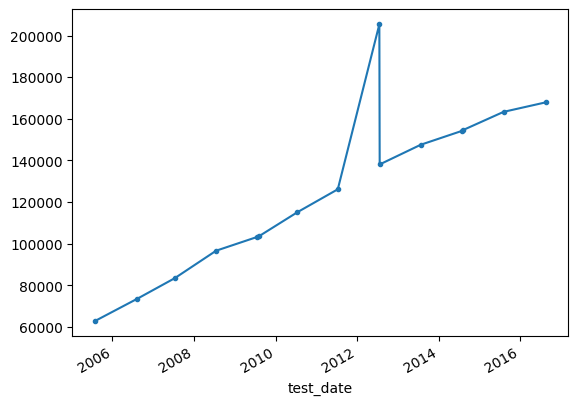

In [22]:
rover_df.set_index('test_date').test_mileage.plot(marker='.')

## Items

In [23]:
item_files_df = csv_info_df[csv_info_df.file.str.contains('item')]
item_files_df

,file,lineterminator,quoting,doublequote,delimiter,quotechar,skipinitialspace
0,data/test_item_2005.txt,\r\n,0,False,|,"""",False
1,data/test_item_2006.txt,\r\n,0,False,|,"""",False
2,data/test_item_2007.txt,\r\n,0,False,|,"""",False
3,data/test_item_2008.txt,\r\n,0,False,|,"""",False
4,data/test_item_2009.txt,\r\n,0,False,|,"""",False
5,data/test_item_2010.txt,\r\n,0,False,|,"""",False
6,data/test_item_2011.txt,\r\n,0,False,|,"""",False
7,data/test_item_2012.txt,\r\n,0,False,|,"""",False
8,data/test_item_2013.txt,\r\n,0,False,|,"""",False
9,data/test_item_2014.txt,\r\n,0,False,|,"""",False


In [24]:
def read_items(file, sep):
    df = dd.read_csv(file,
                     delimiter=sep,
                     dtype={'dangerous_mark': 'string[pyarrow]'},
                     dtype_backend='pyarrow',
                     # engine='pyarrow',
                    )
        
    return df

item_records = item_files_df[['file', 'delimiter']].to_records(index=False)
item_ddfs = [read_items(file, sep) for file, sep in item_records]

In [25]:
item_ddf = dd.concat(item_ddfs)

In [26]:
item_ddf.dtypes

test_id                      int64[pyarrow]
rfr_id                       int64[pyarrow]
rfr_type_code               string[pyarrow]
location_id                  int64[pyarrow]
dangerous_mark              string[pyarrow]
test_class_id                int64[pyarrow]
test_item_id                 int64[pyarrow]
minor_item                  string[pyarrow]
rfr_deficiency_category     string[pyarrow]
rfr_desc                    string[pyarrow]
rfr_loc_marker              string[pyarrow]
rfr_insp_manual_desc        string[pyarrow]
rfr_advisory_text           string[pyarrow]
test_item_set_section_id     int64[pyarrow]
parent_id                    int64[pyarrow]
item_name                   string[pyarrow]
dtype: object

In [27]:
item_ddf.info()
item_ddf.head()

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, test_id to item_name
dtypes: int64[pyarrow](7), string(1), string[pyarrow](8)

,test_id,rfr_id,rfr_type_code,location_id,dangerous_mark,test_class_id,test_item_id,minor_item,rfr_deficiency_category,rfr_desc,rfr_loc_marker,rfr_insp_manual_desc,rfr_advisory_text,test_item_set_section_id,parent_id,item_name
0,1343771031,8394,A,7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,1560692612,8394,F,13,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,1560692612,7977,F,9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,1560692612,7916,A,7,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,1560692612,7916,A,9,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [28]:
f = (
    item_ddf
    .to_parquet('item.parquet', write_index=False, overwrite=True, compute=False)
    .persist()
)

progress(f)

VBox()

In [29]:
item_ddf = dd.read_parquet('item.parquet')

ValueError: An error occurred while calling the read_parquet method registered to the pandas backend.
Original Message: No files satisfy the `parquet_file_extension` criteria (files must end with ('.parq', '.parquet', '.pq')).

In [ ]:
rfr_counts = item_ddf.rfr_id.value_counts().compute()

In [ ]:
rfr_counts

## Reasons for rejection (test fail)

Not sure if this includes advisories

In [ ]:
rfr_df = dd.read_csv('data/unzipped/dft_item_detail.csv', sep='|', dtype_backend='pyarrow')
rfr_df.info(verbose=True)
rfr_df.head()

In [ ]:
rfr_df.query('rfr_id == 8394').compute()